In [112]:
import matplotlib.pyplot as plt
import numpy as np
import sdf
import glob
import tqdm
import os
import re
from tabulate import tabulate

plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)
import sys

In [113]:
directory = "4run"
save_dir = "plots"

In [114]:
try:
    file_dir = os.path.dirname(os.path.realpath(__file__))
except NameError:
    file_dir = os.getcwd()
DATA_DIR = os.path.join(file_dir, directory)
SAVE_DIR = os.path.join(file_dir, save_dir)

ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
POINTS = len(ALL_FILES)
print(f"Found {POINTS} files")

main_info = {"SDF Files": POINTS}

# Constants
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12
kb = 1.38064852e-23

# Loading Parameters
with open(os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data = myfile.read()


def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None


def find_angle(data):
    angle_reg = re.compile(
        "upper_theta\s+=\s+(\d{0,3})\s{0,3}\*?\s{0,3}pi\s{0,3}\/\s{0,3}(\d{0,3})"
    )
    try:
        a, b = angle_reg.search(data).groups()
    except AttributeError:
        angle_pretty = 0
        angle_rad = 0
        angle_degree = 0
        return angle_pretty, angle_degree, angle_rad

    angle_pretty = f"{a}π/{b}"
    if not a and not b:
        raise ValueError("Angle is not parsed correctly.")
    if not a:
        a = 1
    if not b:
        b = 1
    angle_rad = int(a) * PI / int(b)
    angle_degree = angle_rad * 180 / PI
    angle_degree = round(angle_degree, 1)
    return angle_pretty, angle_degree, angle_rad


raw_data = sdf.read(ALL_FILES[0])

LAMBD = find_value("lambda0") * 1e-6
X, Y = raw_data.Grid_Grid.data
X = X / LAMBD
Y = Y / LAMBD
X_MIN = X.min()
X_MAX = X.max()
Y_MIN = Y.min()
Y_MAX = Y.max()
NX = int(find_value("cells_x"))
NY = int(find_value("cells_y"))
EXTENT = [X_MIN, X_MAX, Y_MIN, Y_MAX]
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("simulation_end"))
DT = find_value("snapshot_freq") * 1e-15
A0 = find_value("a0")
NX = int(find_value("cells_x"))
NY = int(find_value("cells_y"))
angle_pretty, angle_degree, ANGLE = find_angle(data)

main_info["Lambda"] = LAMBD
main_info["Extent"] = EXTENT
main_info["Cells in X"] = NX
main_info["Cells in Y"] = NY
main_info["Laser Time"] = LAS_TIME
main_info["Max Time"] = T_MAX
main_info["Delta T"] = DT
main_info["A0"] = A0
main_info["Angle in Degree"] = angle_degree
main_info["Angle"] = angle_pretty

# Calculating Parameters
omega0 = 2 * PI * c / LAMBD
tau = 2 * PI / omega0
nc = epsilon * m * omega0**2 / e**2
Er = m * omega0 * c / e
LAS_TIME = LAS_TIME * tau
f_max = 1 / (2 * DT)
omega_max = 2 * PI * f_max
omega_max_natural = omega_max / omega0
calculated_info = {
    "Omega0": omega0,
    "Tau": tau,
    "Critical Density": nc,
    "Electric Field": Er,
    "Laser Time": LAS_TIME,
    "Max Resolvable Frequency": f_max,
    "Max Resolvable Omega": omega_max_natural,
}

table_main = tabulate(main_info.items(), headers=["Parameter", "Value"])
table_calculated = tabulate(calculated_info.items(), headers=["Parameter", "Value"])
print(table_main)
print(table_calculated)

Found 18 files
Parameter        Value
---------------  ---------------------------------------
SDF Files        18
Lambda           1e-06
Extent           [-8.0, 1.9999999999999996, -10.0, 10.0]
Cells in X       2000
Cells in Y       4000
Laser Time       6
Max Time         15
Delta T          3.0000000000000002e-15
A0               1.0
Angle in Degree  0
Angle            0
Parameter                       Value
------------------------  -----------
Omega0                    1.88365e+15
Tau                       3.33564e-15
Critical Density          1.11433e+27
Electric Field            3.2107e+12
Laser Time                2.00138e-14
Max Resolvable Frequency  1.66667e+14
Max Resolvable Omega      0.55594


In [115]:
omega = np.linspace(-omega_max_natural, omega_max_natural, len(ALL_FILES))
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

In [116]:
def plot_field(data_dir, ax, component="y"):
    raw_data = sdf.read(data_dir)
    comp = {
        # "x":raw_data.Electric_Field_Ex,
        "y":raw_data.Electric_Field_Ey,
        # "z":raw_data.Electric_Field_Ez,
    }
    field = comp[component].data.T
    t = raw_data.Header['time']*1e15
    field = field/(field.max()+1e-10)
    ax.imshow(field**2, cmap='jet', origin='lower',
    extent=EXTENT,
    aspect='auto',
    )
    ax.set_xlabel('$x \, [\mu m]$')
    ax.set_ylabel('$y \, [\mu m]$')
    ax.set_title(f't = {t:.1f} fs')


def get_field(id, component):
    raw_data = sdf.read(ALL_FILES[id])
    comp = {
        # "x":raw_data.Electric_Field_Ex,
        "y":raw_data.Electric_Field_Ey,
        # "z":raw_data.Electric_Field_Ez,
    }
    field = comp[component].data.T
    return field

In [117]:
NX*=0.2
NY*=0.2

In [118]:
def x_position_to_node(x):
    return int((x - X_MIN)/(X_MAX - X_MIN)*NX)

def y_position_to_node(y):
    return int((y - Y_MIN)/(Y_MAX - Y_MIN)*NY)

In [119]:
# plot_field(ALL_FILES[3], plt.gca(), component="y")

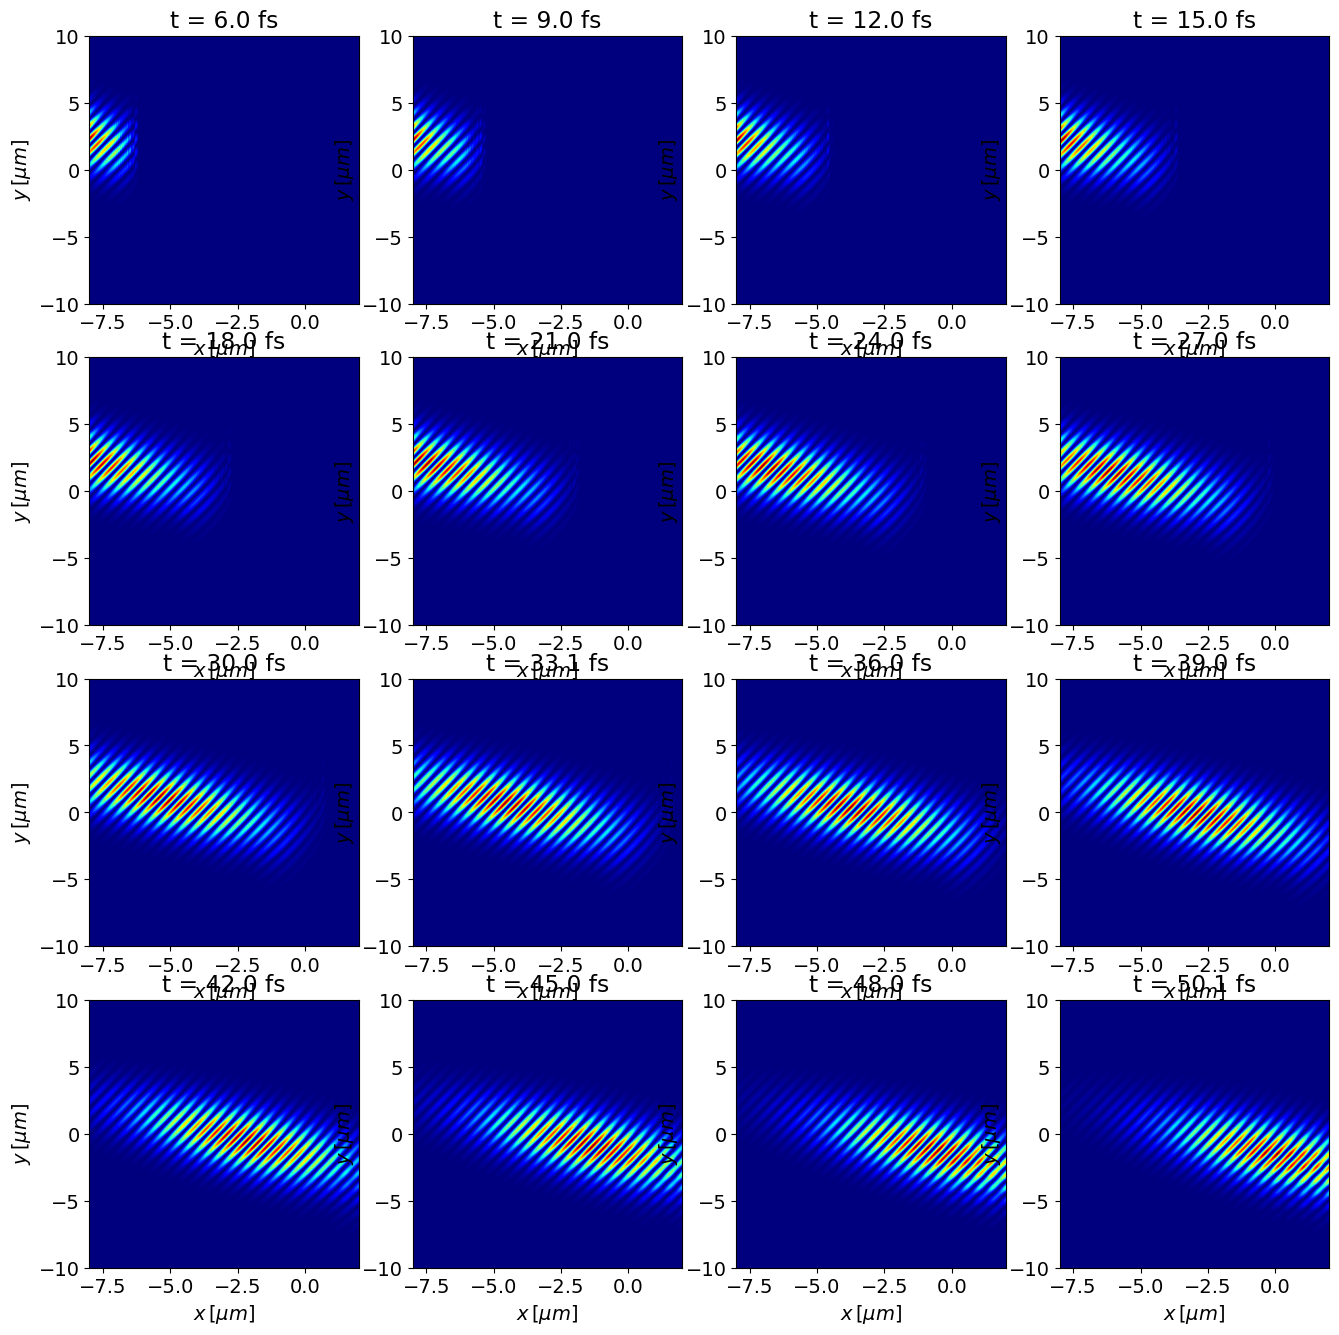

In [120]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        plot_field(ALL_FILES[i*4+j+2], ax[i, j], component="y")